In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = '50 percent More hold LSTM Time Series - cyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Prepare Test Data

In [5]:
nr_test_sets = ['C6L.SI','O39.SI','0883.HK','JPM','AXL']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
            
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    print(X.shape)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-21         9.59  9.538960 -32.758553  6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007  7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362  7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822  6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884  8160300.0     2.0
(218, 15, 4)
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-21        11.75  11.523654 -10.869606  21160951.0     2.0
2019-01-22        11.73  11.555399 -13.978517  18040951.0     2.0
2019-01-23        11.50  11.546876 -38.709667  14286851.0     1.0
2019-01-24        11.38  11.521203 -51.612890   8454651.0     2.0
2019-01-25        11.41  11.504095 -80.357185  12469051.0     2.0
(218, 15, 4)
            previous_1d     EMA_12   willr_14        OBV_7  labe

In [6]:
r_test_sets = ['C6L.SI','O39.SI','0883.HK','JPM','AXL']
r_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
            
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    print(X.shape)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         8.84  8.979182 -96.551645  -851200.0     2.0
2020-01-23         8.93  8.971615 -65.517105  1644900.0     2.0
2020-01-24         8.85  8.952905 -92.307523  -246900.0     2.0
2020-01-28         8.82  8.932458 -75.000000 -1718200.0     2.0
2020-01-29         8.56  8.875157 -86.885115 -5499900.0     2.0
(215, 15, 4)
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22        11.12  11.072811 -24.444379  27489400.0     2.0
2020-01-23        11.19  11.090840  -8.888884  31751200.0     2.0
2020-01-24        11.11  11.093787 -26.666653  27359800.0     2.0
2020-01-28        11.10  11.094743 -28.888715  24699300.0     2.0
2020-01-29        10.90  11.064783 -71.739257  16499235.0     2.0
(215, 15, 4)
            previous_1d     EMA_12   willr_14        OBV_7  labe

## Train Accumulation Phase Stock Data

In [7]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [8]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [9]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

### Creating Training Data and Model

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


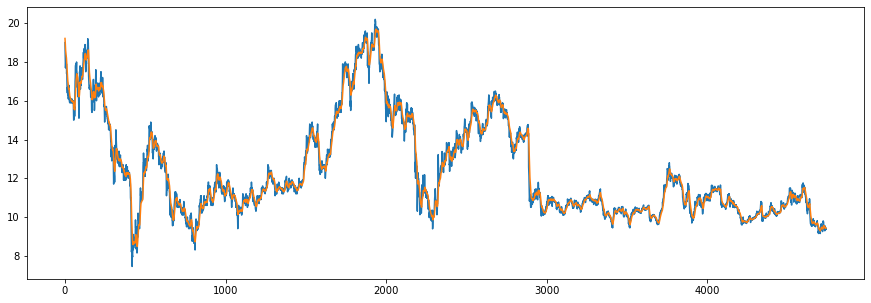

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


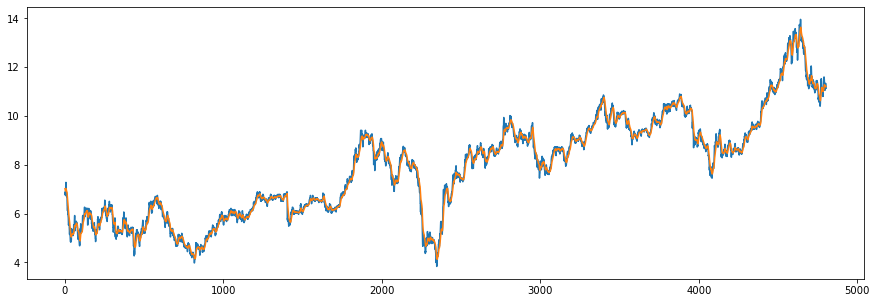

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2000-01-24     3.189194  3.249583 -69.696967   61394527.0     2.0
2000-01-25     3.205140  3.242745 -79.136806   75032521.0     2.0
2000-01-26     3.402870  3.267380 -34.532549  127274101.0     2.0
2000-01-27     3.284870  3.270071 -62.500055   91746305.0     2.0
2000-01-28     3.252978  3.267441 -69.852957   65314909.0     2.0


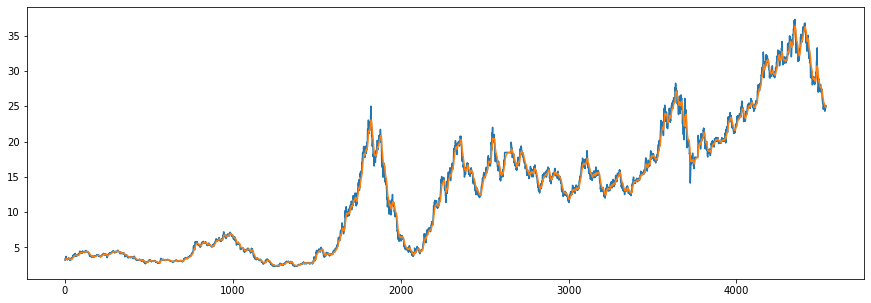

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


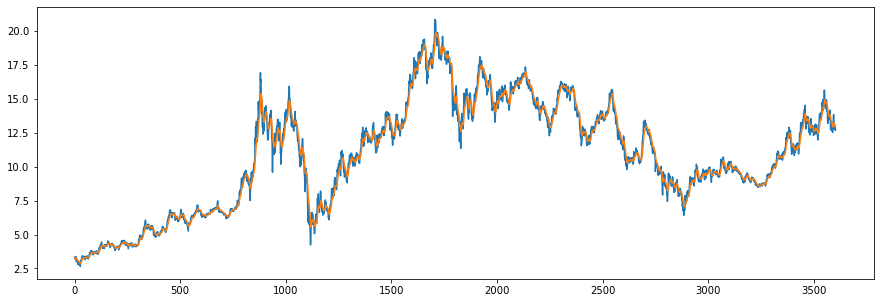

            previous_1d    EMA_12   willr_14         OBV_7  labels
Date                                                              
2006-11-17     3.953848  3.652647 -15.942120  1.897904e+10     2.0
2006-11-20     3.934226  3.695967 -18.840636  1.837444e+10     2.0
2006-11-21     3.934226  3.732622 -19.403036  1.837444e+10     2.0
2006-11-22     3.934226  3.763638 -19.697025  1.837444e+10     0.0
2006-11-23     4.051959  3.807995  -1.562480  1.907354e+10     2.0


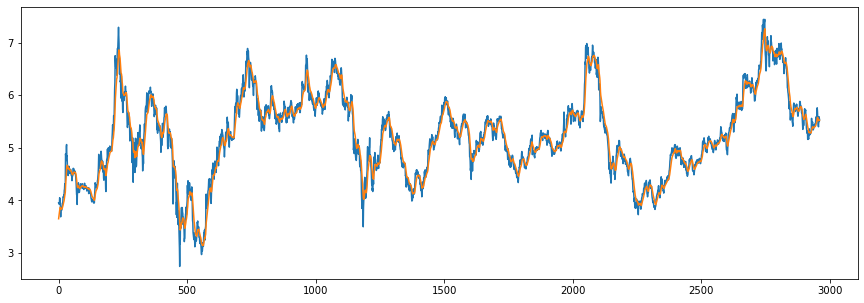

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      21.5000  24.211693 -82.142857  -6805500.0     2.0
2000-01-24      20.2500  23.602201 -92.465753  -8986800.0     1.0
2000-01-25      20.1875  23.076863 -92.307692 -11383100.0     2.0
2000-01-26      20.8750  22.738115 -82.786885  -9392500.0     2.0
2000-01-27      22.8750  22.759174 -56.557377  -6811000.0     2.0


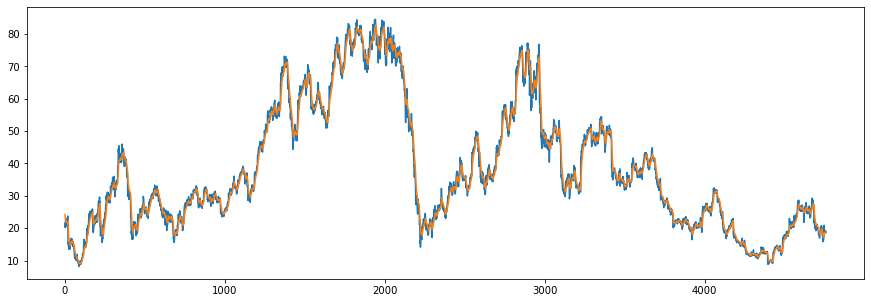

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


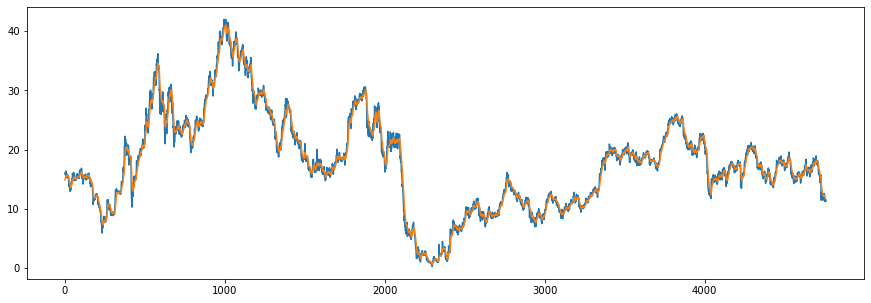

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


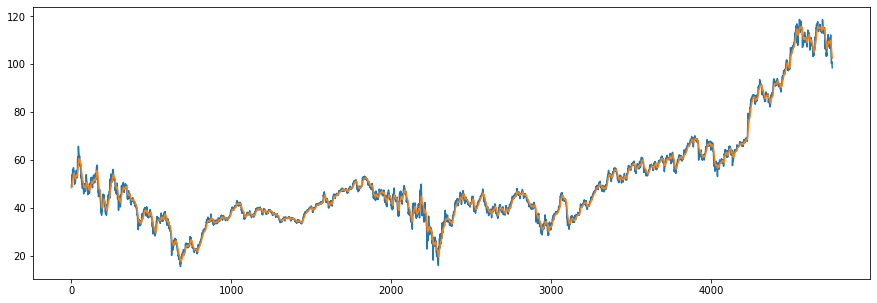

            previous_1d     EMA_12    willr_14     OBV_7  labels
Date                                                            
2000-01-21      13.7500  14.817184  -97.297297 -827200.0     2.0
2000-01-24      14.0625  14.701079  -77.500000 -518900.0     2.0
2000-01-25      13.6875  14.545144  -92.500000 -906100.0     2.0
2000-01-26      13.7500  14.422814  -90.000000 -652700.0     2.0
2000-01-27      13.5000  14.280843 -100.000000 -848400.0     2.0


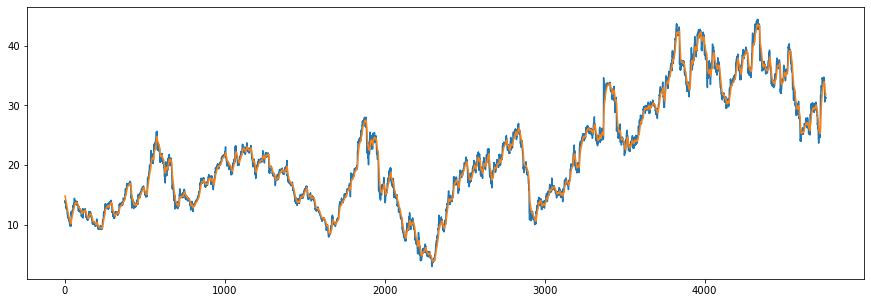

            previous_1d     EMA_12  willr_14      OBV_7  labels
Date                                                           
2010-12-21    18.799999  18.175961      -0.0  1579000.0     0.0
2010-12-22    19.000000  18.302736      -0.0  1699000.0     2.0
2010-12-23    19.000000  18.410008      -0.0  1699000.0     2.0
2010-12-27    19.000000  18.500776      -0.0  1699000.0     2.0
2010-12-28    19.000000  18.577580      -0.0  1699000.0     2.0


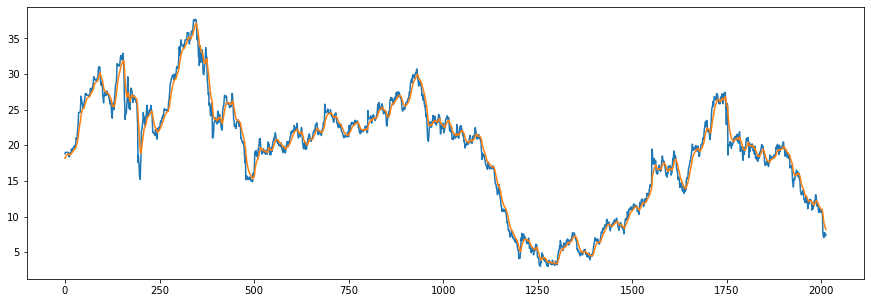

In [10]:
labels = []
sequential = []

train_sets = ['C6L.SI','O39.SI','600104.SS','0883.HK','1398.HK','ANF','AXL','JPM','CTB','TROX']

for name in train_sets:
    seed = 10
    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    data_15 = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1

In [11]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(41550, 15, 4)

In [12]:
y = labels
y = np.array(y)
y.shape

(41550,)

In [13]:
from collections import Counter

Counter(y)

Counter({2.0: 37853, 0.0: 1852, 1.0: 1845})

In [14]:
X = sequential
y = labels

class_0 = []
class_1 = []
class_2 = []

class_0_labels = []
class_1_labels = []
class_2_labels = []

for i in range (0,len(y)):
    if y[i] == 0:
        class_0.append(X[i])
        class_0_labels.append(y[i])
    if y[i] == 1:
        class_1.append(X[i])
        class_1_labels.append(y[i])
    if y[i] == 2:
        class_2.append(X[i])
        class_2_labels.append(y[i])
        
class_0 = class_0[0:923]
class_1 = class_1[0:923]
class_2 = class_2[0:1845]

class_0_labels = class_0_labels[0:923]
class_1_labels = class_1_labels[0:923]
class_2_labels = class_2_labels[0:1845]

X = class_0 + class_1 + class_2
y = class_0_labels + class_1_labels + class_2_labels

X  = np.array(X).reshape(-1, 15, 4)
y = np.array(y)

print(X.shape)

Counter(y)

(3691, 15, 4)


Counter({0.0: 923, 1.0: 923, 2.0: 1845})

In [15]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [16]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [17]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [19]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

epochs = 0 
histories = {}
log_hist = {}

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['C6L.SI','O39.SI','0883.HK','JPM','AXL']
    
    for name in test_sets:
        
        print('\n')
        print(name)
        print('\n')
        
        print('Non-Recession Test')
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('Recession Test')
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('non_recession_{}_{}epochs.csv'.format(experiment,epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('recession_{}_{}epochs.csv'.format(experiment,epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 1 ... 2 0 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "





RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/24 [>.............................] - ETA: 0s - loss: 0.3832 - accuracy: 0.3281 - mse: 0.4246 - weighted_accuracy: 0.2513 - weighted_mse: 0.4601WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
24/24 [==============================] - 1s 44ms/step - loss: 0.2888 - accuracy: 0.3828 - mse: 0.5003 - weighted_accuracy: 0.3363 - weighted_mse: 0.5193 - val_loss: 0.2993 - val_accuracy: 0.2585 - val_mse: 0.3493 - val_weighted_accuracy: 0.2585 - val_weighted_mse: 0.3493
Epoch 2/20
24/24 [==============================] - 0s 9ms/step - loss: 0.2057 - accuracy: 0.4363 - mse: 0.7860 - weighted_accuracy: 0.4688 - weighted_mse: 0.7806 - val_loss: 0.2913 - val_accuracy: 0.2503 - val_mse: 0.3680 - val_weighted_accuracy: 0.25

7/7 [==============================] - 0s 3ms/step - loss: 0.1769 - accuracy: 0.3953 - mse: 1.2371 - weighted_accuracy: 0.3953 - weighted_mse: 1.2371
Test loss: 0.17693862318992615
Test accuracy: 0.39534884691238403


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 3
actual sells but predicted hold: 3
actual holds but predicted buy: 103
actual holds but predicted sell: 20
actual predicted holds: 75
Percentage buys correct: 6.1946902654867255%
Percentage sells correct: 13.043478260869565%
Percentage holds correct: 94.9367088607595%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 42.47787610619469%
Percentage high sells correct: 65.21739130434783%
Percentage mid holds correct: 89.74358974358974%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price

7/7 [==============================] - 0s 3ms/step - loss: 0.1717 - accuracy: 0.4787 - mse: 1.2093 - weighted_accuracy: 0.4787 - weighted_mse: 1.2093
Test loss: 0.17173555493354797
Test accuracy: 0.47867298126220703


number of predictions: 211
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 80
actual holds but predicted sell: 17
actual predicted holds: 97
Percentage buys correct: 4.705882352941177%
Percentage sells correct: 0.0%
Percentage holds correct: 88.9908256880734%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 49.411764705882355%
Percentage high sells correct: 62.5%
Percentage mid holds correct: 81.65137614678899%


Capital: 100
Share price: $0.6441463755029468
Shares owned at the moment: 154
Cash capital at the moment: $0.5286621825206907


Price increase from previously bou

7/7 [==============================] - 0s 3ms/step - loss: 0.1663 - accuracy: 0.5434 - mse: 1.1760 - weighted_accuracy: 0.5434 - weighted_mse: 1.1760
Test loss: 0.1662714183330536
Test accuracy: 0.543379008769989


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 3
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 65
actual holds but predicted sell: 20
actual predicted holds: 112
Percentage buys correct: 5.555555555555555%
Percentage sells correct: 13.043478260869565%
Percentage holds correct: 90.3225806451613%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 38.888888888888886%
Percentage high sells correct: 60.869565217391305%
Percentage mid holds correct: 82.11382113821138%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the moment: $0.7899973135552756


Price




RUNNING EPOCHS 20 - 40



Epoch 1/20
24/24 [==============================] - 1s 55ms/step - loss: 0.1496 - accuracy: 0.5698 - mse: 1.5097 - weighted_accuracy: 0.6497 - weighted_mse: 1.4893 - val_loss: 0.1810 - val_accuracy: 0.4452 - val_mse: 1.2462 - val_weighted_accuracy: 0.4452 - val_weighted_mse: 1.2462
Epoch 2/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1487 - accuracy: 0.5772 - mse: 1.5183 - weighted_accuracy: 0.6558 - weighted_mse: 1.5006 - val_loss: 0.1793 - val_accuracy: 0.4777 - val_mse: 1.2760 - val_weighted_accuracy: 0.4777 - val_weighted_mse: 1.2760
Epoch 3/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1486 - accuracy: 0.5657 - mse: 1.5517 - weighted_accuracy: 0.6497 - weighted_mse: 1.5304 - val_loss: 0.1778 - val_accuracy: 0.4980 - val_mse: 1.2367 - val_weighted_accuracy: 0.4980 - val_weighted_mse: 1.2367
Epoch 4/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1476 - accuracy: 0.5766 - mse: 1.5713 - weighted_a

7/7 [==============================] - 0s 3ms/step - loss: 0.1966 - accuracy: 0.3628 - mse: 1.8344 - weighted_accuracy: 0.3628 - weighted_mse: 1.8344
Test loss: 0.1965576559305191
Test accuracy: 0.36279070377349854


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 79
actual holds but predicted sell: 54
actual predicted holds: 65
Percentage buys correct: 8.045977011494253%
Percentage sells correct: 10.0%
Percentage holds correct: 95.58823529411765%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 49.42528735632184%
Percentage high sells correct: 61.666666666666664%
Percentage mid holds correct: 89.55223880597015%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from 

7/7 [==============================] - 0s 3ms/step - loss: 0.2234 - accuracy: 0.2930 - mse: 1.9209 - weighted_accuracy: 0.2930 - weighted_mse: 1.9209
Test loss: 0.22339463233947754
Test accuracy: 0.2930232584476471


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 76
actual holds but predicted sell: 70
actual predicted holds: 47
Percentage buys correct: 8.433734939759036%
Percentage sells correct: 11.25%
Percentage holds correct: 90.38461538461539%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 53.01204819277108%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 86.27450980392157%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price increase from previously 

2         -54.689601  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.2043 - accuracy: 0.3427 - mse: 1.9006 - weighted_accuracy: 0.3427 - weighted_mse: 1.9006
Test loss: 0.2042599469423294
Test accuracy: 0.34272301197052


number of predictions: 213
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 5
actual sells but predicted hold: 2
actual holds but predicted buy: 80
actual holds but predicted sell: 54
actual predicted holds: 59
Percentage buys correct: 9.782608695652174%
Percentage sells correct: 8.474576271186441%
Percentage holds correct: 95.16129032258064%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 50.0%
Percentage high sells correct: 60.3448275862069%
Percentage mid holds correct: 88.70967741935483%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20

7/7 [==============================] - 0s 3ms/step - loss: 0.1871 - accuracy: 0.3790 - mse: 1.8142 - weighted_accuracy: 0.3790 - weighted_mse: 1.8142
Test loss: 0.18712349236011505
Test accuracy: 0.37899544835090637


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 3
actual holds but predicted buy: 62
actual holds but predicted sell: 67
actual predicted holds: 68
Percentage buys correct: 8.823529411764707%
Percentage sells correct: 11.842105263157896%
Percentage holds correct: 90.66666666666667%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 56.578947368421055%
Percentage mid holds correct: 81.08108108108108%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the moment: $0.7899973135552756


Price increase f

7/7 [==============================] - 0s 3ms/step - loss: 0.1981 - accuracy: 0.4018 - mse: 1.9020 - weighted_accuracy: 0.4018 - weighted_mse: 1.9020
Test loss: 0.19805924594402313
Test accuracy: 0.4018264710903168


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 4
actual holds but predicted buy: 59
actual holds but predicted sell: 67
actual predicted holds: 71
Percentage buys correct: 14.492753623188406%
Percentage sells correct: 9.45945945945946%
Percentage holds correct: 93.42105263157895%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 62.31884057971015%
Percentage high sells correct: 58.108108108108105%
Percentage mid holds correct: 85.33333333333333%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Pric

24/24 [==============================] - 0s 8ms/step - loss: 0.1344 - accuracy: 0.6511 - mse: 1.8147 - weighted_accuracy: 0.7148 - weighted_mse: 1.8082 - val_loss: 0.1669 - val_accuracy: 0.5589 - val_mse: 1.9153 - val_weighted_accuracy: 0.5589 - val_weighted_mse: 1.9153
Epoch 10/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1339 - accuracy: 0.6416 - mse: 1.8159 - weighted_accuracy: 0.7053 - weighted_mse: 1.8079 - val_loss: 0.1769 - val_accuracy: 0.5250 - val_mse: 1.9852 - val_weighted_accuracy: 0.5250 - val_weighted_mse: 1.9852
Epoch 11/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1327 - accuracy: 0.6474 - mse: 1.7963 - weighted_accuracy: 0.7166 - weighted_mse: 1.7851 - val_loss: 0.1678 - val_accuracy: 0.5413 - val_mse: 1.9187 - val_weighted_accuracy: 0.5413 - val_weighted_mse: 1.9187
Epoch 12/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1322 - accuracy: 0.6528 - mse: 1.8282 - weighted_accuracy: 0.7121 - weighted_mse: 1.8223

7/7 [==============================] - 0s 3ms/step - loss: 0.2131 - accuracy: 0.3442 - mse: 2.1399 - weighted_accuracy: 0.3442 - weighted_mse: 2.1399
Test loss: 0.21314111351966858
Test accuracy: 0.34418603777885437


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 81
actual holds but predicted sell: 56
actual predicted holds: 61
Percentage buys correct: 7.954545454545454%
Percentage sells correct: 9.67741935483871%
Percentage holds correct: 93.84615384615384%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 48.86363636363637%
Percentage high sells correct: 61.29032258064516%
Percentage mid holds correct: 85.9375%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase fro

7/7 [==============================] - 0s 3ms/step - loss: 0.2366 - accuracy: 0.2930 - mse: 2.2192 - weighted_accuracy: 0.2930 - weighted_mse: 2.2192
Test loss: 0.2365516722202301
Test accuracy: 0.2930232584476471


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 75
actual holds but predicted sell: 71
actual predicted holds: 47
Percentage buys correct: 8.536585365853659%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 90.38461538461539%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 52.4390243902439%
Percentage high sells correct: 60.49382716049383%
Percentage mid holds correct: 84.31372549019608%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price in

7/7 [==============================] - 0s 4ms/step - loss: 0.2159 - accuracy: 0.3615 - mse: 2.2398 - weighted_accuracy: 0.3615 - weighted_mse: 2.2398
Test loss: 0.21593238413333893
Test accuracy: 0.36150234937667847


number of predictions: 213
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 71
actual holds but predicted sell: 59
actual predicted holds: 63
Percentage buys correct: 9.876543209876543%
Percentage sells correct: 9.23076923076923%
Percentage holds correct: 94.02985074626865%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 50.617283950617285%
Percentage high sells correct: 57.8125%
Percentage mid holds correct: 86.56716417910448%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price increase

7/7 [==============================] - 0s 3ms/step - loss: 0.1946 - accuracy: 0.3881 - mse: 2.1124 - weighted_accuracy: 0.3881 - weighted_mse: 2.1124
Test loss: 0.19460953772068024
Test accuracy: 0.388127863407135


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 10
actual sells but predicted hold: 2
actual holds but predicted buy: 56
actual holds but predicted sell: 71
actual predicted holds: 70
Percentage buys correct: 8.19672131147541%
Percentage sells correct: 12.195121951219512%
Percentage holds correct: 92.10526315789474%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.81967213114754%
Percentage high sells correct: 57.31707317073171%
Percentage mid holds correct: 84.0%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the moment: $0.7899973135552756


Price increase from

4         -40.196200  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.2051 - accuracy: 0.4064 - mse: 2.2406 - weighted_accuracy: 0.4064 - weighted_mse: 2.2406
Test loss: 0.2051338255405426
Test accuracy: 0.4063926935195923


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 52
actual holds but predicted sell: 72
actual predicted holds: 73
Percentage buys correct: 14.516129032258064%
Percentage sells correct: 8.860759493670885%
Percentage holds correct: 93.58974358974359%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 62.295081967213115%
Percentage high sells correct: 59.49367088607595%
Percentage mid holds correct: 85.8974358974359%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at 

24/24 [==============================] - 0s 8ms/step - loss: 0.1253 - accuracy: 0.6863 - mse: 1.9684 - weighted_accuracy: 0.7464 - weighted_mse: 1.9642 - val_loss: 0.1686 - val_accuracy: 0.5399 - val_mse: 2.1137 - val_weighted_accuracy: 0.5399 - val_weighted_mse: 2.1137
Epoch 9/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1247 - accuracy: 0.6873 - mse: 1.9946 - weighted_accuracy: 0.7407 - weighted_mse: 1.9948 - val_loss: 0.1664 - val_accuracy: 0.5548 - val_mse: 2.0755 - val_weighted_accuracy: 0.5548 - val_weighted_mse: 2.0755
Epoch 10/20
24/24 [==============================] - 0s 7ms/step - loss: 0.1236 - accuracy: 0.6833 - mse: 1.9702 - weighted_accuracy: 0.7383 - weighted_mse: 1.9699 - val_loss: 0.1728 - val_accuracy: 0.5426 - val_mse: 2.1233 - val_weighted_accuracy: 0.5426 - val_weighted_mse: 2.1233
Epoch 11/20
24/24 [==============================] - 0s 7ms/step - loss: 0.1231 - accuracy: 0.6958 - mse: 1.9734 - weighted_accuracy: 0.7529 - weighted_mse: 1.9693 

7/7 [==============================] - 0s 3ms/step - loss: 0.2430 - accuracy: 0.3581 - mse: 2.3564 - weighted_accuracy: 0.3581 - weighted_mse: 2.3564
Test loss: 0.24300162494182587
Test accuracy: 0.3581395447254181


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 78
actual holds but predicted sell: 56
actual predicted holds: 64
Percentage buys correct: 8.235294117647058%
Percentage sells correct: 9.67741935483871%
Percentage holds correct: 94.11764705882354%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 47.05882352941177%
Percentage high sells correct: 59.67741935483871%
Percentage mid holds correct: 86.56716417910448%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price inc

7/7 [==============================] - 0s 3ms/step - loss: 0.2547 - accuracy: 0.3023 - mse: 2.3553 - weighted_accuracy: 0.3023 - weighted_mse: 2.3553
Test loss: 0.2547263205051422
Test accuracy: 0.302325576543808


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 73
actual holds but predicted sell: 71
actual predicted holds: 49
Percentage buys correct: 8.75%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 90.74074074074075%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 52.5%
Percentage high sells correct: 59.25925925925926%
Percentage mid holds correct: 86.79245283018868%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price increase from previously bou

7/7 [==============================] - 0s 3ms/step - loss: 0.2326 - accuracy: 0.3756 - mse: 2.3937 - weighted_accuracy: 0.3756 - weighted_mse: 2.3937
Test loss: 0.23261024057865143
Test accuracy: 0.3755868673324585


number of predictions: 213
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 69
actual holds but predicted sell: 57
actual predicted holds: 67
Percentage buys correct: 10.126582278481013%
Percentage sells correct: 8.064516129032258%
Percentage holds correct: 93.05555555555556%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 53.164556962025316%
Percentage high sells correct: 59.01639344262295%
Percentage mid holds correct: 86.11111111111111%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Pri


Share price: $0.518280275824534
Shares owned at the moment: 2480
Cash capital at the moment: $0.36976816041851635


Price increase from previously bought: -12.186923732061905%
Share price: $0.4563694279896795
Shares owned at the moment: 0
Cash capital at the moment: $1129.053510075934


Share price: $0.7455416142246933
Shares owned at the moment: 1510
Cash capital at the moment: $0.1898110435788567


Price increase from previously bought: 3.201898936430214%
Share price: $0.7715289892751118
Shares owned at the moment: 0
Cash capital at the moment: $1161.9948107210328


Share price: $0.7659238615434714
Shares owned at the moment: 1512
Cash capital at the moment: $0.7332206510061496


Price increase from previously bought: 6.426623680315702%
Share price: $0.8173885597935697
Shares owned at the moment: 0
Cash capital at the moment: $1233.226021427262


Share price: $0.8612102554632799
Shares owned at the moment: 1428
Cash capital at the moment: $0.03580395249400681


Price increase from p

7/7 [==============================] - 0s 3ms/step - loss: 0.2571 - accuracy: 0.2706 - mse: 2.4164 - weighted_accuracy: 0.2706 - weighted_mse: 2.4164
Test loss: 0.25707805156707764
Test accuracy: 0.2706421911716461


number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 3
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 83
actual holds but predicted sell: 71
actual predicted holds: 48
Percentage buys correct: 4.597701149425287%
Percentage sells correct: 8.641975308641975%
Percentage holds correct: 96.0%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 43.67816091954023%
Percentage high sells correct: 51.851851851851855%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.7426007274823263
Shares owned at the moment: 134
Cash capital at the moment: $0.21785414929102842


Price increase from




RUNNING EPOCHS 80 - 100



Epoch 1/20
24/24 [==============================] - 0s 14ms/step - loss: 0.1176 - accuracy: 0.7049 - mse: 2.1110 - weighted_accuracy: 0.7586 - weighted_mse: 2.1110 - val_loss: 0.1749 - val_accuracy: 0.5399 - val_mse: 2.2619 - val_weighted_accuracy: 0.5399 - val_weighted_mse: 2.2619
Epoch 2/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1171 - accuracy: 0.7121 - mse: 2.0967 - weighted_accuracy: 0.7622 - weighted_mse: 2.1005 - val_loss: 0.1714 - val_accuracy: 0.5507 - val_mse: 2.2405 - val_weighted_accuracy: 0.5507 - val_weighted_mse: 2.2405
Epoch 3/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1174 - accuracy: 0.7080 - mse: 2.1227 - weighted_accuracy: 0.7597 - weighted_mse: 2.1245 - val_loss: 0.1700 - val_accuracy: 0.5589 - val_mse: 2.1834 - val_weighted_accuracy: 0.5589 - val_weighted_mse: 2.1834
Epoch 4/20
24/24 [==============================] - 0s 8ms/step - loss: 0.1180 - accuracy: 0.7124 - mse: 2.1211 - weighted_

7/7 [==============================] - 0s 3ms/step - loss: 0.2718 - accuracy: 0.3674 - mse: 2.6206 - weighted_accuracy: 0.3674 - weighted_mse: 2.6206
Test loss: 0.27183353900909424
Test accuracy: 0.367441862821579


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 75
actual holds but predicted sell: 57
actual predicted holds: 66
Percentage buys correct: 8.536585365853659%
Percentage sells correct: 9.523809523809524%
Percentage holds correct: 94.28571428571429%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 47.5609756097561%
Percentage high sells correct: 58.73015873015873%
Percentage mid holds correct: 85.5072463768116%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price incre

1         -55.902029  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.2707 - accuracy: 0.3116 - mse: 2.5731 - weighted_accuracy: 0.3116 - weighted_mse: 2.5731
Test loss: 0.2707315981388092
Test accuracy: 0.31162789463996887


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 73
actual holds but predicted sell: 68
actual predicted holds: 52
Percentage buys correct: 8.75%
Percentage sells correct: 10.38961038961039%
Percentage holds correct: 89.65517241379311%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 52.5%
Percentage high sells correct: 58.44155844155844%
Percentage mid holds correct: 87.71929824561404%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.86225577728

7/7 [==============================] - 0s 3ms/step - loss: 0.2506 - accuracy: 0.3897 - mse: 2.6426 - weighted_accuracy: 0.3897 - weighted_mse: 2.6426
Test loss: 0.250572144985199
Test accuracy: 0.38967135548591614


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 68
actual holds but predicted sell: 54
actual predicted holds: 71
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 8.474576271186441%
Percentage holds correct: 92.20779220779221%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 51.94805194805195%
Percentage high sells correct: 58.62068965517241%
Percentage mid holds correct: 84.41558441558442%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price 

7/7 [==============================] - 0s 3ms/step - loss: 0.2134 - accuracy: 0.4384 - mse: 2.4478 - weighted_accuracy: 0.4384 - weighted_mse: 2.4478
Test loss: 0.21335086226463318
Test accuracy: 0.4383561611175537


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 4
actual holds but predicted buy: 50
actual holds but predicted sell: 65
actual predicted holds: 82
Percentage buys correct: 12.068965517241379%
Percentage sells correct: 9.58904109589041%
Percentage holds correct: 93.18181818181819%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 56.89655172413793%
Percentage high sells correct: 58.9041095890411%
Percentage mid holds correct: 85.05747126436782%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the moment: $0.7899973135552756


Price i

7/7 [==============================] - 0s 3ms/step - loss: 0.2221 - accuracy: 0.4064 - mse: 2.5818 - weighted_accuracy: 0.4064 - weighted_mse: 2.5818
Test loss: 0.22210349142551422
Test accuracy: 0.4063926935195923


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 5
actual holds but predicted buy: 53
actual holds but predicted sell: 68
actual predicted holds: 76
Percentage buys correct: 11.666666666666666%
Percentage sells correct: 8.108108108108109%
Percentage holds correct: 89.41176470588235%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 57.6271186440678%
Percentage high sells correct: 59.45945945945946%
Percentage mid holds correct: 82.3529411764706%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Price i

24/24 [==============================] - 0s 9ms/step - loss: 0.1049 - accuracy: 0.7652 - mse: 2.3916 - weighted_accuracy: 0.8031 - weighted_mse: 2.3988 - val_loss: 0.1721 - val_accuracy: 0.5900 - val_mse: 2.4081 - val_weighted_accuracy: 0.5900 - val_weighted_mse: 2.4081
Epoch 10/20
24/24 [==============================] - 0s 9ms/step - loss: 0.1035 - accuracy: 0.7629 - mse: 2.3786 - weighted_accuracy: 0.8006 - weighted_mse: 2.3868 - val_loss: 0.1817 - val_accuracy: 0.5589 - val_mse: 2.5533 - val_weighted_accuracy: 0.5589 - val_weighted_mse: 2.5533
Epoch 11/20
24/24 [==============================] - 0s 9ms/step - loss: 0.1038 - accuracy: 0.7642 - mse: 2.3983 - weighted_accuracy: 0.8026 - weighted_mse: 2.4024 - val_loss: 0.1726 - val_accuracy: 0.5805 - val_mse: 2.5802 - val_weighted_accuracy: 0.5805 - val_weighted_mse: 2.5802
Epoch 12/20
24/24 [==============================] - 0s 9ms/step - loss: 0.1023 - accuracy: 0.7751 - mse: 2.4339 - weighted_accuracy: 0.8080 - weighted_mse: 2.4386

7/7 [==============================] - 0s 3ms/step - loss: 0.3128 - accuracy: 0.3488 - mse: 2.9669 - weighted_accuracy: 0.3488 - weighted_mse: 2.9669
Test loss: 0.31283822655677795
Test accuracy: 0.3488371968269348


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 78
actual holds but predicted sell: 58
actual predicted holds: 62
Percentage buys correct: 8.235294117647058%
Percentage sells correct: 9.375%
Percentage holds correct: 93.93939393939394%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 47.05882352941177%
Percentage high sells correct: 57.8125%
Percentage mid holds correct: 86.15384615384616%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from previously

7/7 [==============================] - 0s 3ms/step - loss: 0.3053 - accuracy: 0.2930 - mse: 2.8809 - weighted_accuracy: 0.2930 - weighted_mse: 2.8809
Test loss: 0.305280864238739
Test accuracy: 0.2930232584476471


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 77
actual holds but predicted sell: 69
actual predicted holds: 47
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 11.39240506329114%
Percentage holds correct: 90.38461538461539%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 53.57142857142857%
Percentage high sells correct: 59.49367088607595%
Percentage mid holds correct: 88.23529411764706%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price in

7/7 [==============================] - 0s 3ms/step - loss: 0.2818 - accuracy: 0.3803 - mse: 2.9714 - weighted_accuracy: 0.3803 - weighted_mse: 2.9714
Test loss: 0.2817841172218323
Test accuracy: 0.3802816867828369


number of predictions: 213
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 67
actual holds but predicted sell: 58
actual predicted holds: 68
Percentage buys correct: 10.38961038961039%
Percentage sells correct: 7.936507936507937%
Percentage holds correct: 93.15068493150685%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 51.94805194805195%
Percentage high sells correct: 59.67741935483871%
Percentage mid holds correct: 83.56164383561644%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price 

Shares owned at the moment: 4785
Cash capital at the moment: $0.24116097937030645


Price increase from previously bought: -13.706635914793964%
Share price: $0.4484713994839227
Shares owned at the moment: 0
Cash capital at the moment: $2140.275484481981


Share price: $0.7455416142246933
Shares owned at the moment: 2862
Cash capital at the moment: $0.6675992961531847


Price increase from previously bought: 3.201898936430214%
Share price: $0.7715289892751118
Shares owned at the moment: 0
Cash capital at the moment: $2202.711247691433


Share price: $0.7659238615434714
Shares owned at the moment: 2868
Cash capital at the moment: $0.0007712887636444066


Price increase from previously bought: 6.426623680315702%
Share price: $0.8173885597935697
Shares owned at the moment: 0
Cash capital at the moment: $2337.8244172056293


Share price: $0.8612102554632799
Shares owned at the moment: 2707
Cash capital at the moment: $0.1171912222980609


Price increase from previously bought: 1.84993650961

7/7 [==============================] - 0s 3ms/step - loss: 0.3013 - accuracy: 0.2661 - mse: 2.9299 - weighted_accuracy: 0.2661 - weighted_mse: 2.9299
Test loss: 0.3013380765914917
Test accuracy: 0.26605504751205444


number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 2
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 78
actual holds but predicted sell: 74
actual predicted holds: 50
Percentage buys correct: 3.7037037037037037%
Percentage sells correct: 6.172839506172839%
Percentage holds correct: 89.28571428571429%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 44.44444444444444%
Percentage high sells correct: 56.79012345679013%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $0.7426007274823263
Shares owned at the moment: 134
Cash capital at the moment: $0.21785414929102842


Price increase from

Epoch 1/20
24/24 [==============================] - 0s 15ms/step - loss: 0.0973 - accuracy: 0.7910 - mse: 2.5730 - weighted_accuracy: 0.8279 - weighted_mse: 2.5771 - val_loss: 0.1940 - val_accuracy: 0.5494 - val_mse: 2.7738 - val_weighted_accuracy: 0.5494 - val_weighted_mse: 2.7738
Epoch 2/20
24/24 [==============================] - 0s 11ms/step - loss: 0.0975 - accuracy: 0.7862 - mse: 2.5558 - weighted_accuracy: 0.8209 - weighted_mse: 2.5631 - val_loss: 0.1807 - val_accuracy: 0.5697 - val_mse: 2.7667 - val_weighted_accuracy: 0.5697 - val_weighted_mse: 2.7667
Epoch 3/20
24/24 [==============================] - 0s 9ms/step - loss: 0.0968 - accuracy: 0.7835 - mse: 2.5791 - weighted_accuracy: 0.8187 - weighted_mse: 2.5842 - val_loss: 0.1770 - val_accuracy: 0.6022 - val_mse: 2.6789 - val_weighted_accuracy: 0.6022 - val_weighted_mse: 2.6789
Epoch 4/20
24/24 [==============================] - 0s 9ms/step - loss: 0.0980 - accuracy: 0.7873 - mse: 2.5817 - weighted_accuracy: 0.8200 - weighted_m

7/7 [==============================] - 0s 3ms/step - loss: 0.3528 - accuracy: 0.3674 - mse: 3.2681 - weighted_accuracy: 0.3674 - weighted_mse: 3.2681
Test loss: 0.35277998447418213
Test accuracy: 0.367441862821579


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 76
actual holds but predicted sell: 57
actual predicted holds: 65
Percentage buys correct: 9.523809523809524%
Percentage sells correct: 9.523809523809524%
Percentage holds correct: 95.58823529411765%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 51.19047619047619%
Percentage high sells correct: 60.317460317460316%
Percentage mid holds correct: 88.05970149253731%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price in

7/7 [==============================] - 0s 3ms/step - loss: 0.3434 - accuracy: 0.2791 - mse: 3.1897 - weighted_accuracy: 0.2791 - weighted_mse: 3.1897
Test loss: 0.3433966040611267
Test accuracy: 0.27906978130340576


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 77
actual holds but predicted sell: 70
actual predicted holds: 46
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 8.974358974358974%
Percentage holds correct: 86.79245283018868%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 54.76190476190476%
Percentage high sells correct: 58.97435897435897%
Percentage mid holds correct: 82.6923076923077%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price i

7/7 [==============================] - 0s 3ms/step - loss: 0.3100 - accuracy: 0.3662 - mse: 3.2507 - weighted_accuracy: 0.3662 - weighted_mse: 3.2507
Test loss: 0.310031920671463
Test accuracy: 0.3661971688270569


number of predictions: 213
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 69
actual holds but predicted sell: 59
actual predicted holds: 65
Percentage buys correct: 10.126582278481013%
Percentage sells correct: 7.8125%
Percentage holds correct: 92.85714285714286%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 51.89873417721519%
Percentage high sells correct: 58.73015873015873%
Percentage mid holds correct: 81.42857142857143%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price increase fr

7/7 [==============================] - 0s 3ms/step - loss: 0.2749 - accuracy: 0.3562 - mse: 3.0469 - weighted_accuracy: 0.3562 - weighted_mse: 3.0469
Test loss: 0.2749033570289612
Test accuracy: 0.3561643958091736


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 65
actual holds but predicted sell: 68
actual predicted holds: 64
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 10.38961038961039%
Percentage holds correct: 91.42857142857143%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 51.388888888888886%
Percentage high sells correct: 58.44155844155844%
Percentage mid holds correct: 82.6086956521739%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the moment: $0.7899973135552756


Price i

7/7 [==============================] - 0s 3ms/step - loss: 0.2900 - accuracy: 0.3744 - mse: 3.1898 - weighted_accuracy: 0.3744 - weighted_mse: 3.1898
Test loss: 0.28999486565589905
Test accuracy: 0.37442922592163086


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 54
actual holds but predicted sell: 74
actual predicted holds: 69
Percentage buys correct: 9.836065573770492%
Percentage sells correct: 8.641975308641975%
Percentage holds correct: 89.6103896103896%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 58.333333333333336%
Percentage high sells correct: 60.49382716049383%
Percentage mid holds correct: 83.11688311688312%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Price

24/24 [==============================] - 0s 9ms/step - loss: 0.0864 - accuracy: 0.8178 - mse: 2.8617 - weighted_accuracy: 0.8476 - weighted_mse: 2.8617 - val_loss: 0.1872 - val_accuracy: 0.5995 - val_mse: 2.9903 - val_weighted_accuracy: 0.5995 - val_weighted_mse: 2.9903
Epoch 4/20
24/24 [==============================] - 0s 9ms/step - loss: 0.0880 - accuracy: 0.8194 - mse: 2.8784 - weighted_accuracy: 0.8460 - weighted_mse: 2.8722 - val_loss: 0.1970 - val_accuracy: 0.5940 - val_mse: 3.1738 - val_weighted_accuracy: 0.5940 - val_weighted_mse: 3.1738
Epoch 5/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0853 - accuracy: 0.8401 - mse: 2.9117 - weighted_accuracy: 0.8625 - weighted_mse: 2.9122 - val_loss: 0.1935 - val_accuracy: 0.5995 - val_mse: 3.1877 - val_weighted_accuracy: 0.5995 - val_weighted_mse: 3.1877
Epoch 6/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0858 - accuracy: 0.8289 - mse: 2.9072 - weighted_accuracy: 0.8552 - weighted_mse: 2.9068 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.3852 - accuracy: 0.3814 - mse: 3.7085 - weighted_accuracy: 0.3814 - weighted_mse: 3.7085
Test loss: 0.3852492868900299
Test accuracy: 0.3813953399658203


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 76
actual holds but predicted sell: 55
actual predicted holds: 67
Percentage buys correct: 9.523809523809524%
Percentage sells correct: 11.290322580645162%
Percentage holds correct: 97.10144927536231%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 51.19047619047619%
Percentage high sells correct: 59.67741935483871%
Percentage mid holds correct: 86.76470588235294%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price in

7/7 [==============================] - 0s 3ms/step - loss: 0.3631 - accuracy: 0.3256 - mse: 3.5973 - weighted_accuracy: 0.3256 - weighted_mse: 3.5973
Test loss: 0.3631178140640259
Test accuracy: 0.3255814015865326


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 66
actual holds but predicted sell: 70
actual predicted holds: 57
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 8.974358974358974%
Percentage holds correct: 87.6923076923077%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 56.94444444444444%
Percentage high sells correct: 60.256410256410255%
Percentage mid holds correct: 84.375%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price increase fro

2         -54.689601  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.3330 - accuracy: 0.3897 - mse: 3.7044 - weighted_accuracy: 0.3897 - weighted_mse: 3.7044
Test loss: 0.3330436050891876
Test accuracy: 0.38967135548591614


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 67
actual holds but predicted sell: 55
actual predicted holds: 71
Percentage buys correct: 9.210526315789474%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 92.20779220779221%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 51.31578947368421%
Percentage high sells correct: 57.6271186440678%
Percentage mid holds correct: 81.81818181818181%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at t

7/7 [==============================] - 0s 3ms/step - loss: 0.2829 - accuracy: 0.3790 - mse: 3.4254 - weighted_accuracy: 0.3790 - weighted_mse: 3.4254
Test loss: 0.2829023003578186
Test accuracy: 0.37899544835090637


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 63
actual holds but predicted sell: 64
actual predicted holds: 70
Percentage buys correct: 7.246376811594203%
Percentage sells correct: 10.95890410958904%
Percentage holds correct: 90.9090909090909%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.72463768115942%
Percentage high sells correct: 60.273972602739725%
Percentage mid holds correct: 82.89473684210526%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the moment: $0.7899973135552756


Price 

7/7 [==============================] - 0s 3ms/step - loss: 0.3042 - accuracy: 0.4155 - mse: 3.5686 - weighted_accuracy: 0.4155 - weighted_mse: 3.5686
Test loss: 0.304228276014328
Test accuracy: 0.4155251085758209


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 50
actual holds but predicted sell: 69
actual predicted holds: 78
Percentage buys correct: 10.526315789473685%
Percentage sells correct: 9.210526315789474%
Percentage holds correct: 90.69767441860465%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 53.57142857142857%
Percentage high sells correct: 59.21052631578947%
Percentage mid holds correct: 83.72093023255815%


Capital: 100
Share price: $0.48894737320923726
Shares owned at the moment: 203
Cash capital at the moment: $0.4707283674307803


Price 

24/24 [==============================] - 0s 8ms/step - loss: 0.0783 - accuracy: 0.8489 - mse: 3.2549 - weighted_accuracy: 0.8706 - weighted_mse: 3.2399 - val_loss: 0.2133 - val_accuracy: 0.6062 - val_mse: 3.5612 - val_weighted_accuracy: 0.6062 - val_weighted_mse: 3.5612
Epoch 5/20
24/24 [==============================] - 0s 10ms/step - loss: 0.0754 - accuracy: 0.8611 - mse: 3.3060 - weighted_accuracy: 0.8805 - weighted_mse: 3.2975 - val_loss: 0.2019 - val_accuracy: 0.6076 - val_mse: 3.5819 - val_weighted_accuracy: 0.6076 - val_weighted_mse: 3.5819
Epoch 6/20
24/24 [==============================] - 0s 10ms/step - loss: 0.0761 - accuracy: 0.8594 - mse: 3.2976 - weighted_accuracy: 0.8803 - weighted_mse: 3.2914 - val_loss: 0.2066 - val_accuracy: 0.6062 - val_mse: 3.6893 - val_weighted_accuracy: 0.6062 - val_weighted_mse: 3.6893
Epoch 7/20
24/24 [==============================] - 0s 9ms/step - loss: 0.0734 - accuracy: 0.8699 - mse: 3.3061 - weighted_accuracy: 0.8871 - weighted_mse: 3.2955 

7/7 [==============================] - 0s 3ms/step - loss: 0.4360 - accuracy: 0.3907 - mse: 4.3073 - weighted_accuracy: 0.3907 - weighted_mse: 4.3073
Test loss: 0.43602991104125977
Test accuracy: 0.3906976878643036


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 75
actual holds but predicted sell: 54
actual predicted holds: 69
Percentage buys correct: 9.63855421686747%
Percentage sells correct: 11.475409836065573%
Percentage holds correct: 97.1830985915493%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 46.98795180722892%
Percentage high sells correct: 59.01639344262295%
Percentage mid holds correct: 87.14285714285714%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price inc

7/7 [==============================] - 0s 3ms/step - loss: 0.4045 - accuracy: 0.3349 - mse: 4.1391 - weighted_accuracy: 0.3349 - weighted_mse: 4.1391
Test loss: 0.4045296013355255
Test accuracy: 0.3348837196826935


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 64
actual holds but predicted sell: 69
actual predicted holds: 60
Percentage buys correct: 8.571428571428571%
Percentage sells correct: 7.894736842105263%
Percentage holds correct: 86.95652173913044%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 58.57142857142857%
Percentage high sells correct: 59.21052631578947%
Percentage mid holds correct: 83.82352941176471%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price i

7/7 [==============================] - 0s 3ms/step - loss: 0.3699 - accuracy: 0.3850 - mse: 4.2615 - weighted_accuracy: 0.3850 - weighted_mse: 4.2615
Test loss: 0.369880348443985
Test accuracy: 0.3849765360355377


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 70
actual holds but predicted sell: 53
actual predicted holds: 70
Percentage buys correct: 8.860759493670885%
Percentage sells correct: 8.620689655172415%
Percentage holds correct: 92.10526315789474%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 49.36708860759494%
Percentage high sells correct: 56.14035087719298%
Percentage mid holds correct: 81.57894736842105%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price i

7/7 [==============================] - 0s 4ms/step - loss: 0.3223 - accuracy: 0.3973 - mse: 3.9515 - weighted_accuracy: 0.3973 - weighted_mse: 3.9515
Test loss: 0.3222578167915344
Test accuracy: 0.39726027846336365


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 4
actual holds but predicted buy: 63
actual holds but predicted sell: 59
actual predicted holds: 75
Percentage buys correct: 7.246376811594203%
Percentage sells correct: 10.447761194029852%
Percentage holds correct: 90.36144578313252%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 52.17391304347826%
Percentage high sells correct: 61.19402985074627%
Percentage mid holds correct: 79.26829268292683%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the moment: $0.7899973135552756


Price

7/7 [==============================] - 0s 3ms/step - loss: 0.3404 - accuracy: 0.4018 - mse: 4.0713 - weighted_accuracy: 0.4018 - weighted_mse: 4.0713
Test loss: 0.3404233753681183
Test accuracy: 0.4018264710903168


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 52
actual holds but predicted sell: 71
actual predicted holds: 74
Percentage buys correct: 10.169491525423728%
Percentage sells correct: 10.126582278481013%
Percentage holds correct: 91.35802469135803%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 53.44827586206897%
Percentage high sells correct: 60.75949367088607%
Percentage mid holds correct: 83.95061728395062%


Capital: 100
Share price: $0.48894737320923726
Shares owned at the moment: 203
Cash capital at the moment: $0.4707283674307803


Pric

24/24 [==============================] - 0s 9ms/step - loss: 0.0661 - accuracy: 0.8723 - mse: 3.6950 - weighted_accuracy: 0.8914 - weighted_mse: 3.6789 - val_loss: 0.2193 - val_accuracy: 0.6306 - val_mse: 4.0762 - val_weighted_accuracy: 0.6306 - val_weighted_mse: 4.0762
Epoch 4/20
24/24 [==============================] - 0s 9ms/step - loss: 0.0690 - accuracy: 0.8757 - mse: 3.7230 - weighted_accuracy: 0.8916 - weighted_mse: 3.6978 - val_loss: 0.2374 - val_accuracy: 0.6076 - val_mse: 4.1666 - val_weighted_accuracy: 0.6076 - val_weighted_mse: 4.1666
Epoch 5/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0661 - accuracy: 0.8814 - mse: 3.7634 - weighted_accuracy: 0.8981 - weighted_mse: 3.7450 - val_loss: 0.2154 - val_accuracy: 0.6184 - val_mse: 4.1760 - val_weighted_accuracy: 0.6184 - val_weighted_mse: 4.1760
Epoch 6/20
24/24 [==============================] - 0s 8ms/step - loss: 0.0673 - accuracy: 0.8825 - mse: 3.7846 - weighted_accuracy: 0.8991 - weighted_mse: 3.7703 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.4866 - accuracy: 0.4093 - mse: 4.9078 - weighted_accuracy: 0.4093 - weighted_mse: 4.9078
Test loss: 0.4865778684616089
Test accuracy: 0.40930232405662537


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 74
actual holds but predicted sell: 50
actual predicted holds: 74
Percentage buys correct: 9.63855421686747%
Percentage sells correct: 10.714285714285714%
Percentage holds correct: 97.36842105263158%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 46.98795180722892%
Percentage high sells correct: 58.92857142857143%
Percentage mid holds correct: 89.33333333333333%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price in

7/7 [==============================] - 0s 3ms/step - loss: 0.4404 - accuracy: 0.3349 - mse: 4.6630 - weighted_accuracy: 0.3349 - weighted_mse: 4.6630
Test loss: 0.4404236078262329
Test accuracy: 0.3348837196826935


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 65
actual holds but predicted sell: 67
actual predicted holds: 61
Percentage buys correct: 8.450704225352112%
Percentage sells correct: 6.8493150684931505%
Percentage holds correct: 85.91549295774648%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 56.33802816901409%
Percentage high sells correct: 56.16438356164384%
Percentage mid holds correct: 82.85714285714286%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price 

7/7 [==============================] - 0s 3ms/step - loss: 0.4013 - accuracy: 0.3944 - mse: 4.7133 - weighted_accuracy: 0.3944 - weighted_mse: 4.7133
Test loss: 0.40125572681427
Test accuracy: 0.39436620473861694


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 73
actual holds but predicted sell: 48
actual predicted holds: 72
Percentage buys correct: 8.536585365853659%
Percentage sells correct: 9.433962264150944%
Percentage holds correct: 92.3076923076923%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 47.5609756097561%
Percentage high sells correct: 55.76923076923077%
Percentage mid holds correct: 80.76923076923077%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price inc

7/7 [==============================] - 0s 3ms/step - loss: 0.3662 - accuracy: 0.3927 - mse: 4.4526 - weighted_accuracy: 0.3927 - weighted_mse: 4.4526
Test loss: 0.3662290573120117
Test accuracy: 0.39269405603408813


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 4
actual holds but predicted buy: 64
actual holds but predicted sell: 59
actual predicted holds: 74
Percentage buys correct: 7.142857142857143%
Percentage sells correct: 10.447761194029852%
Percentage holds correct: 90.2439024390244%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 51.42857142857143%
Percentage high sells correct: 62.6865671641791%
Percentage mid holds correct: 80.24691358024691%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the moment: $0.7899973135552756


Price i

7/7 [==============================] - 0s 3ms/step - loss: 0.3900 - accuracy: 0.3881 - mse: 4.5646 - weighted_accuracy: 0.3881 - weighted_mse: 4.5646
Test loss: 0.3900220990180969
Test accuracy: 0.388127863407135


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 55
actual holds but predicted sell: 70
actual predicted holds: 72
Percentage buys correct: 9.67741935483871%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 90.0%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 54.09836065573771%
Percentage high sells correct: 59.74025974025974%
Percentage mid holds correct: 85.0%


Capital: 100
Share price: $0.48894737320923726
Shares owned at the moment: 203
Cash capital at the moment: $0.4707283674307803


Price increase from previously bou

In [20]:
df = nr_log_hist['0_epochs_logs']
df['Profit gained']

0    -70.083996
1    -72.947167
2    -45.907991
3    211.885050
4    -23.850635
Name: Profit gained, dtype: float64

In [21]:
C6LSI_acc = []
O39SI_acc = []
CNOOC_acc = []
JPM_acc = []
AXL_acc = []

C6LSI_correct_buys = []
O39SI_correct_buys = []
CNOOC_correct_buys = []
JPM_correct_buys = []
AXL_correct_buys = []

C6LSI_correct_sells = []
O39SI_correct_sells = []
CNOOC_correct_sells = []
JPM_correct_sells = []
AXL_correct_sells = []

C6LSI_correct_holds = []
O39SI_correct_holds = []
CNOOC_correct_holds = []
JPM_correct_holds = []
AXL_correct_holds = []

C6LSI_correct_low_buys = []
O39SI_correct_low_buys = []
CNOOC_correct_low_buys = []
JPM_correct_low_buys = []
AXL_correct_low_buys = []

C6LSI_correct_high_sells = []
O39SI_correct_high_sells = []
CNOOC_correct_high_sells = []
JPM_correct_high_sells = []
AXL_correct_high_sells = []

C6LSI_correct_mid_holds = []
O39SI_correct_mid_holds = []
CNOOC_correct_mid_holds = []
JPM_correct_mid_holds = []
AXL_correct_mid_holds = []

C6LSI_profit = []
O39SI_profit = []
CNOOC_profit = []
JPM_profit = []
AXL_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    C6LSI_acc.append(acc[0])
    O39SI_acc.append(acc[1])
    CNOOC_acc.append(acc[2])
    JPM_acc.append(acc[3]) 
    AXL_acc.append(acc[4]) 

    C6LSI_correct_buys.append(correct_buys[0])
    O39SI_correct_buys.append(correct_buys[1]) 
    CNOOC_correct_buys.append(correct_buys[2]) 
    JPM_correct_buys.append(correct_buys[3]) 
    AXL_correct_buys.append(correct_buys[4])
    

    C6LSI_correct_sells.append(correct_sells[0]) 
    O39SI_correct_sells.append(correct_sells[1]) 
    CNOOC_correct_sells.append(correct_sells[2]) 
    JPM_correct_sells.append(correct_sells[3]) 
    AXL_correct_sells.append(correct_sells[4]) 
    

    C6LSI_correct_holds.append(correct_holds[0]) 
    O39SI_correct_holds.append(correct_holds[1])  
    CNOOC_correct_holds.append(correct_holds[2])  
    JPM_correct_holds.append(correct_holds[3])  
    AXL_correct_holds.append(correct_holds[4])  
     

    C6LSI_correct_low_buys.append(correct_low_buys[0])  
    O39SI_correct_low_buys.append(correct_low_buys[1])  
    CNOOC_correct_low_buys.append(correct_low_buys[2])  
    JPM_correct_low_buys.append(correct_low_buys[3])   
    AXL_correct_low_buys.append(correct_low_buys[4])   
    

    C6LSI_correct_high_sells.append(correct_high_sells[0]) 
    O39SI_correct_high_sells.append(correct_high_sells[1]) 
    CNOOC_correct_high_sells.append(correct_high_sells[2]) 
    JPM_correct_high_sells.append(correct_high_sells[3]) 
    AXL_correct_high_sells.append(correct_high_sells[4]) 
    

    C6LSI_correct_mid_holds.append(correct_mid_holds[0])  
    O39SI_correct_mid_holds.append(correct_mid_holds[1])  
    CNOOC_correct_mid_holds.append(correct_mid_holds[2])   
    JPM_correct_mid_holds.append(correct_mid_holds[3])   
    AXL_correct_mid_holds.append(correct_mid_holds[4])   
    

    C6LSI_profit.append(profit[0]) 
    O39SI_profit.append(profit[1]) 
    CNOOC_profit.append(profit[2]) 
    JPM_profit.append(profit[3])  
    AXL_profit.append(profit[4])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


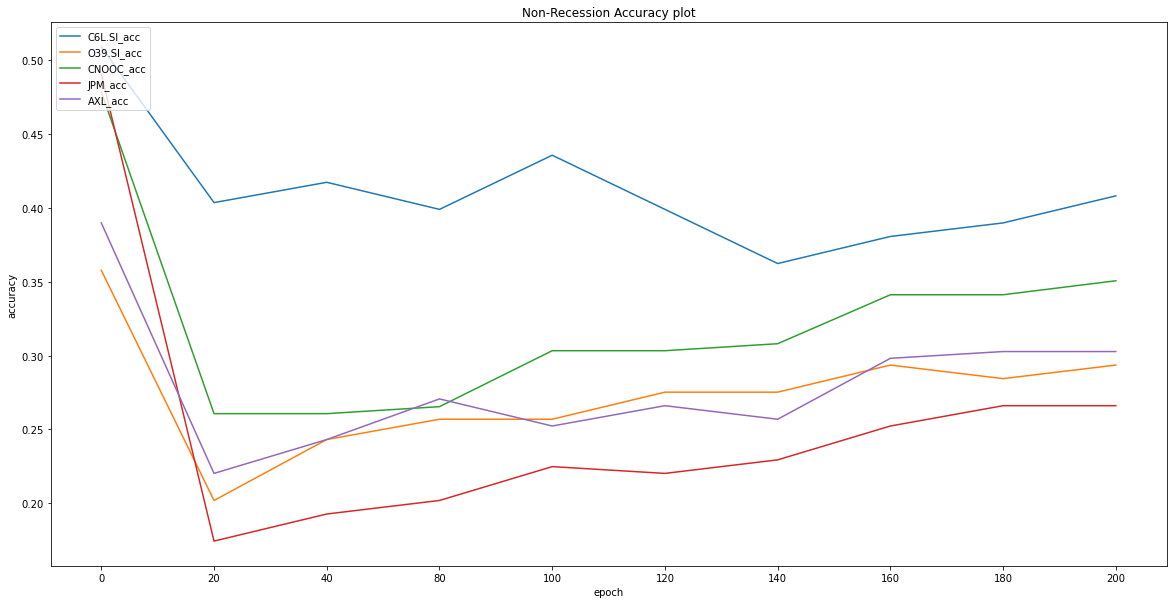

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(C6LSI_acc)
plt.plot(O39SI_acc)
plt.plot(CNOOC_acc)
plt.plot(JPM_acc)
plt.plot(AXL_acc)
plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['C6L.SI_acc','O39.SI_acc','CNOOC_acc','JPM_acc','AXL_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'AXL_correct_buys')

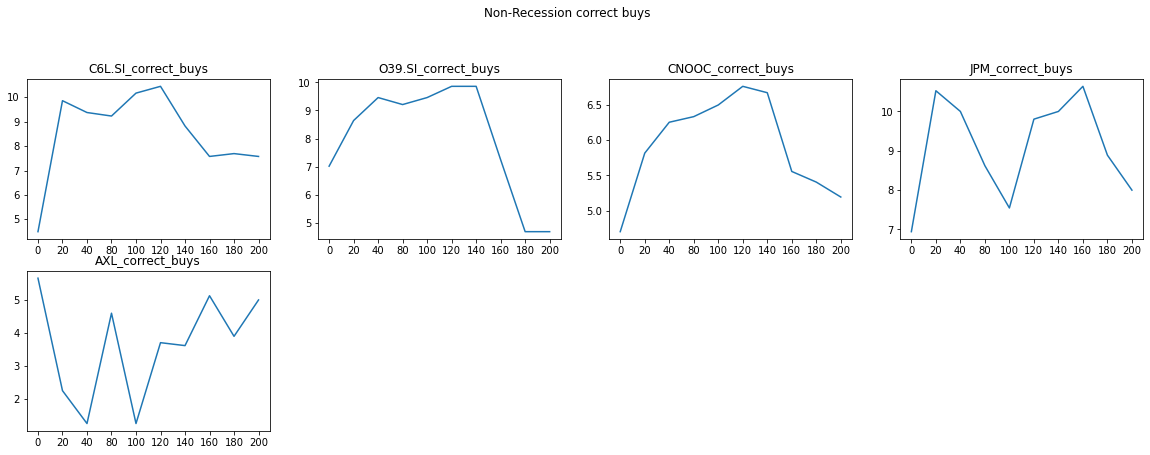

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_buys")

Text(0.5, 1.0, 'AXL_correct_sells')

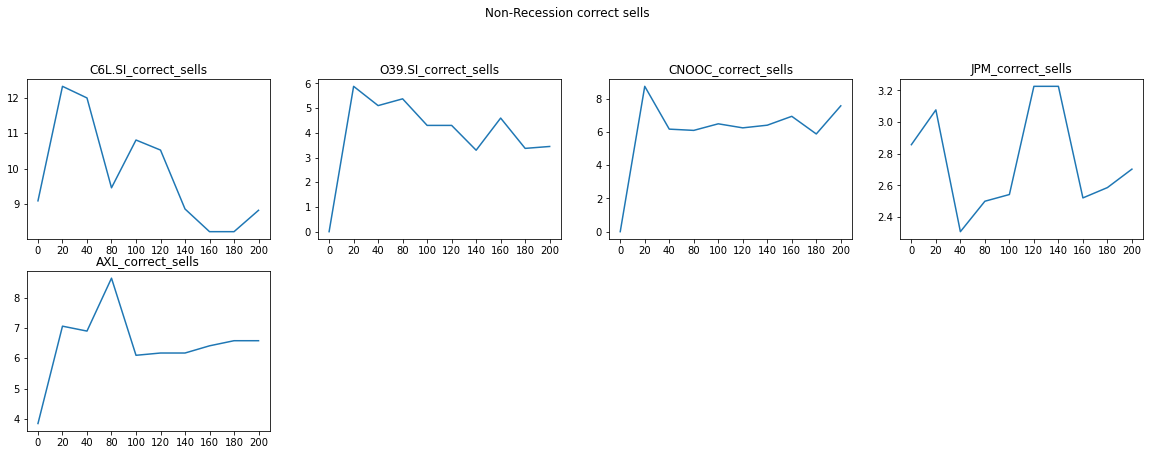

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_sells")

Text(0.5, 1.0, 'AXL_correct_holds')

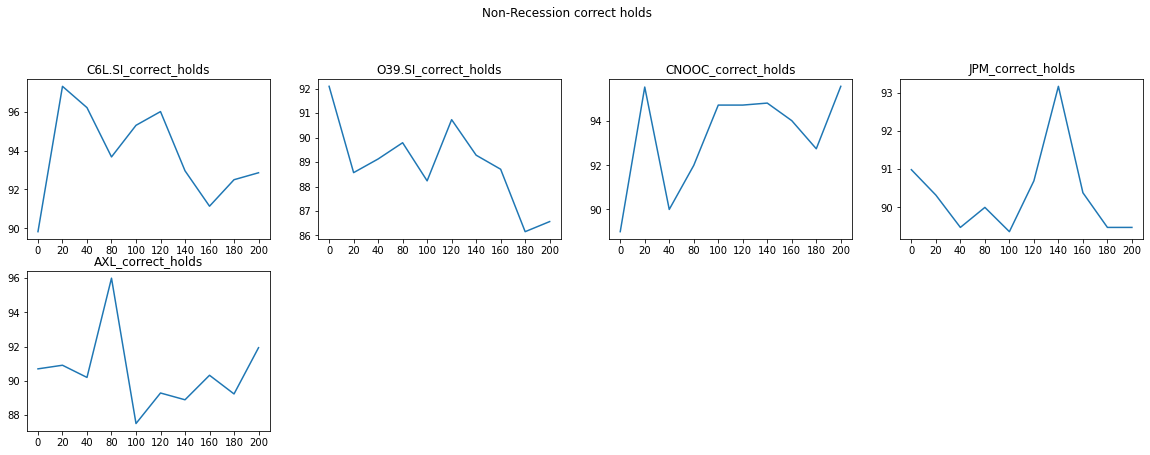

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_holds")

Text(0.5, 1.0, 'AXL_correct_low_buys')

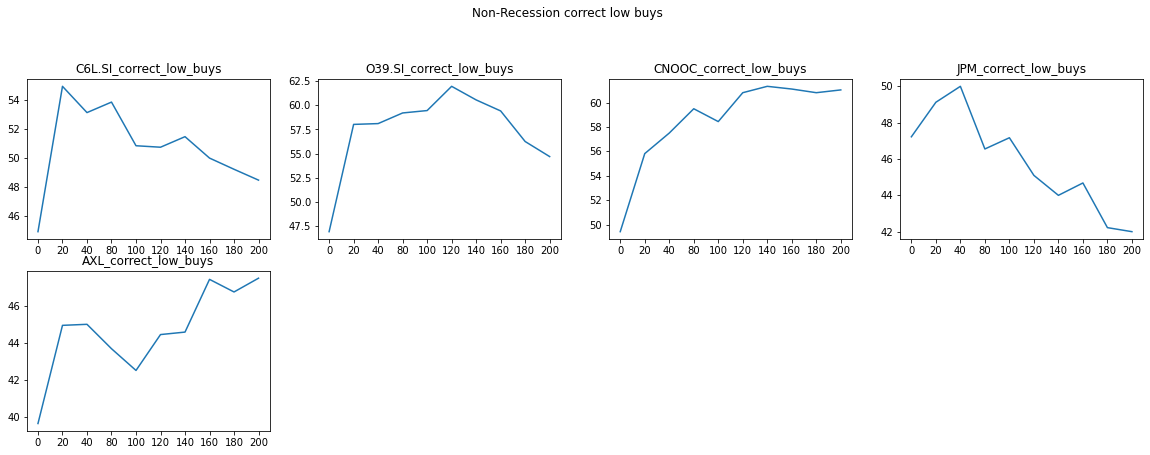

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_low_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_low_buys")

Text(0.5, 1.0, 'AXL_correct_high_sells')

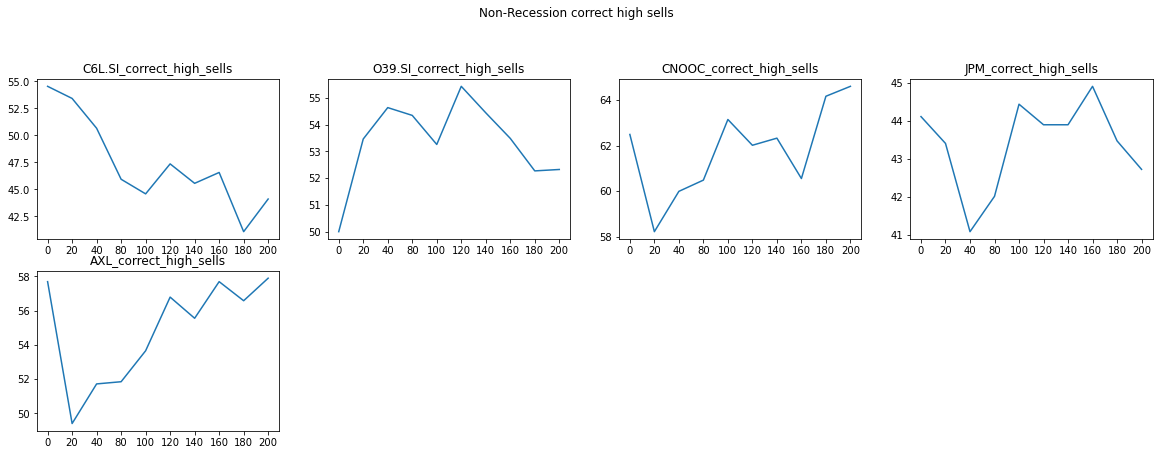

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_high_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_high_sells")

Text(0.5, 1.0, 'AXL_correct_mid_holds')

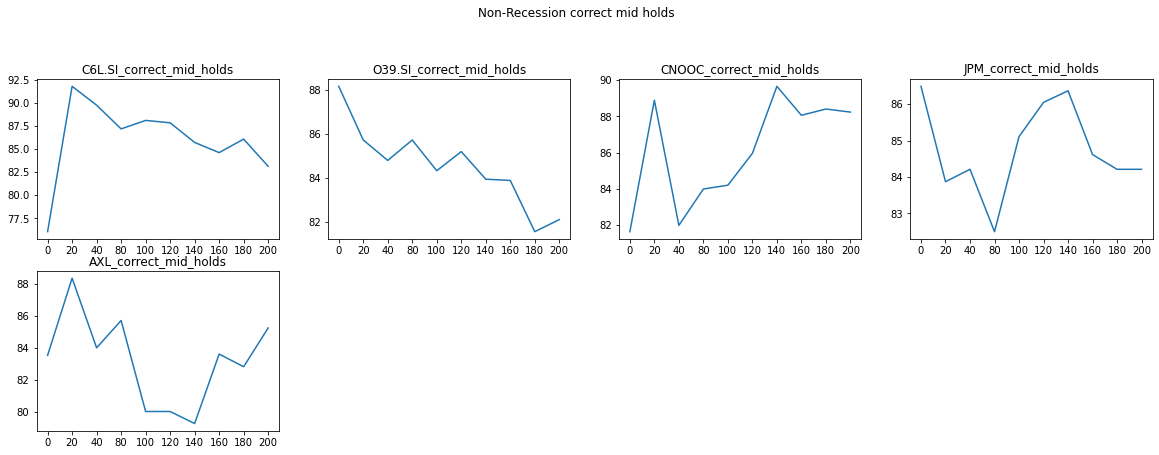

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_mid_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_mid_holds")

Text(0.5, 1.0, 'AXL_profit')

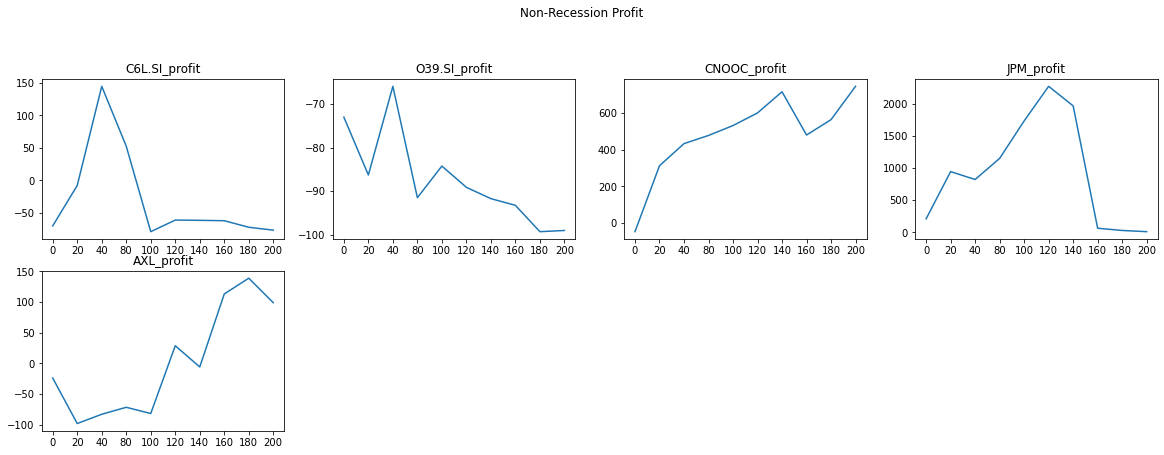

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_profit")

plt.subplot(3, 4, 2)
plt.plot(O39SI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_profit")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_profit")

plt.subplot(3, 4, 4)
plt.plot(JPM_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_profit")

plt.subplot(3, 4, 5)
plt.plot(AXL_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_profit")

In [30]:
C6LSI_acc = []
O39SI_acc = []
CNOOC_acc = []
JPM_acc = []
AXL_acc = []

C6LSI_correct_buys = []
O39SI_correct_buys = []
CNOOC_correct_buys = []
JPM_correct_buys = []
AXL_correct_buys = []

C6LSI_correct_sells = []
O39SI_correct_sells = []
CNOOC_correct_sells = []
JPM_correct_sells = []
AXL_correct_sells = []

C6LSI_correct_holds = []
O39SI_correct_holds = []
CNOOC_correct_holds = []
JPM_correct_holds = []
AXL_correct_holds = []

C6LSI_correct_low_buys = []
O39SI_correct_low_buys = []
CNOOC_correct_low_buys = []
JPM_correct_low_buys = []
AXL_correct_low_buys = []

C6LSI_correct_high_sells = []
O39SI_correct_high_sells = []
CNOOC_correct_high_sells = []
JPM_correct_high_sells = []
AXL_correct_high_sells = []

C6LSI_correct_mid_holds = []
O39SI_correct_mid_holds = []
CNOOC_correct_mid_holds = []
JPM_correct_mid_holds = []
AXL_correct_mid_holds = []

C6LSI_profit = []
O39SI_profit = []
CNOOC_profit = []
JPM_profit = []
AXL_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    C6LSI_acc.append(acc[0])
    O39SI_acc.append(acc[1])
    CNOOC_acc.append(acc[2])
    JPM_acc.append(acc[3]) 
    AXL_acc.append(acc[4]) 

    C6LSI_correct_buys.append(correct_buys[0])
    O39SI_correct_buys.append(correct_buys[1]) 
    CNOOC_correct_buys.append(correct_buys[2]) 
    JPM_correct_buys.append(correct_buys[3]) 
    AXL_correct_buys.append(correct_buys[4])
    

    C6LSI_correct_sells.append(correct_sells[0]) 
    O39SI_correct_sells.append(correct_sells[1]) 
    CNOOC_correct_sells.append(correct_sells[2]) 
    JPM_correct_sells.append(correct_sells[3]) 
    AXL_correct_sells.append(correct_sells[4]) 
    

    C6LSI_correct_holds.append(correct_holds[0]) 
    O39SI_correct_holds.append(correct_holds[1])  
    CNOOC_correct_holds.append(correct_holds[2])  
    JPM_correct_holds.append(correct_holds[3])  
    AXL_correct_holds.append(correct_holds[4])  
     

    C6LSI_correct_low_buys.append(correct_low_buys[0])  
    O39SI_correct_low_buys.append(correct_low_buys[1])  
    CNOOC_correct_low_buys.append(correct_low_buys[2])  
    JPM_correct_low_buys.append(correct_low_buys[3])   
    AXL_correct_low_buys.append(correct_low_buys[4])   
    

    C6LSI_correct_high_sells.append(correct_high_sells[0]) 
    O39SI_correct_high_sells.append(correct_high_sells[1]) 
    CNOOC_correct_high_sells.append(correct_high_sells[2]) 
    JPM_correct_high_sells.append(correct_high_sells[3]) 
    AXL_correct_high_sells.append(correct_high_sells[4]) 
    

    C6LSI_correct_mid_holds.append(correct_mid_holds[0])  
    O39SI_correct_mid_holds.append(correct_mid_holds[1])  
    CNOOC_correct_mid_holds.append(correct_mid_holds[2])   
    JPM_correct_mid_holds.append(correct_mid_holds[3])   
    AXL_correct_mid_holds.append(correct_mid_holds[4])   
    

    C6LSI_profit.append(profit[0]) 
    O39SI_profit.append(profit[1]) 
    CNOOC_profit.append(profit[2]) 
    JPM_profit.append(profit[3])  
    AXL_profit.append(profit[4])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


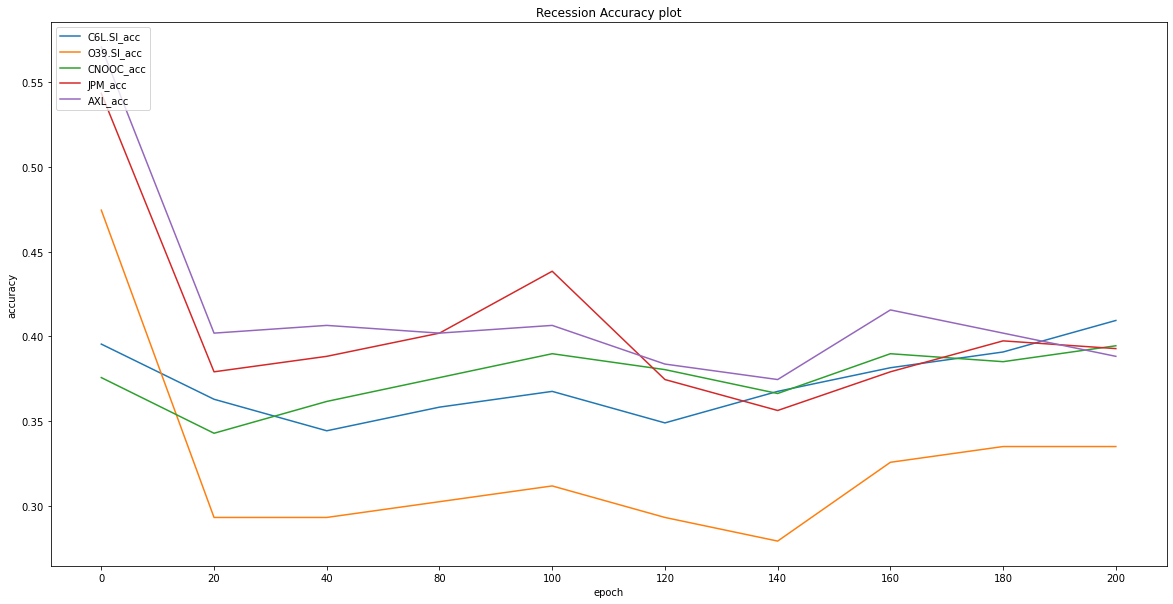

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(C6LSI_acc)
plt.plot(O39SI_acc)
plt.plot(CNOOC_acc)
plt.plot(JPM_acc)
plt.plot(AXL_acc)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['C6L.SI_acc','O39.SI_acc','CNOOC_acc','JPM_acc','AXL_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'AXL_correct_buys')

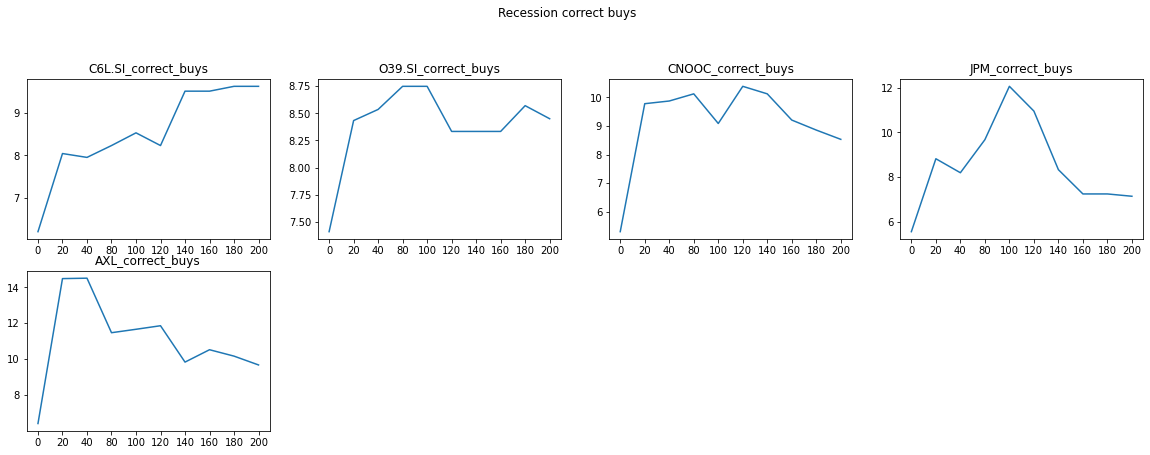

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_buys")

Text(0.5, 1.0, 'AXL_correct_sells')

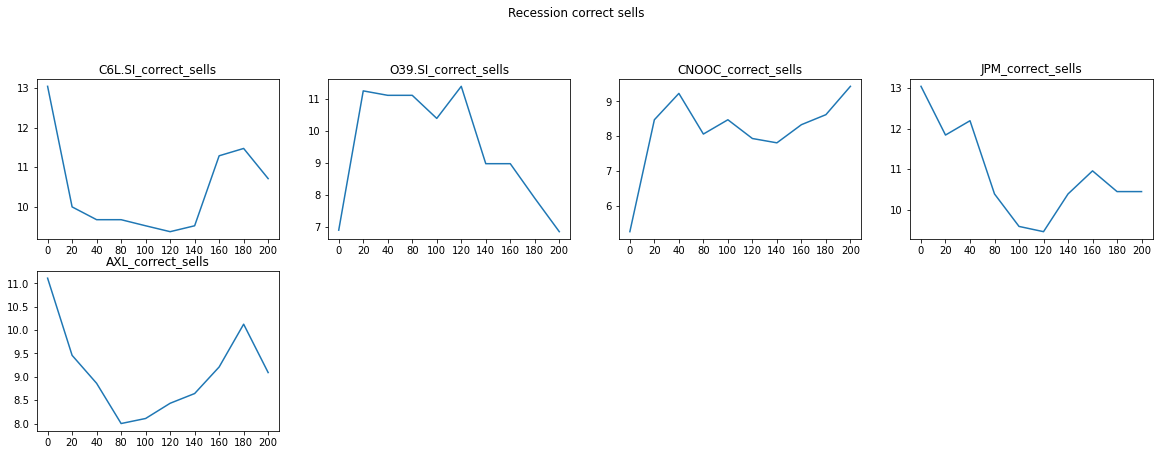

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_sells")

Text(0.5, 1.0, 'AXL_correct_holds')

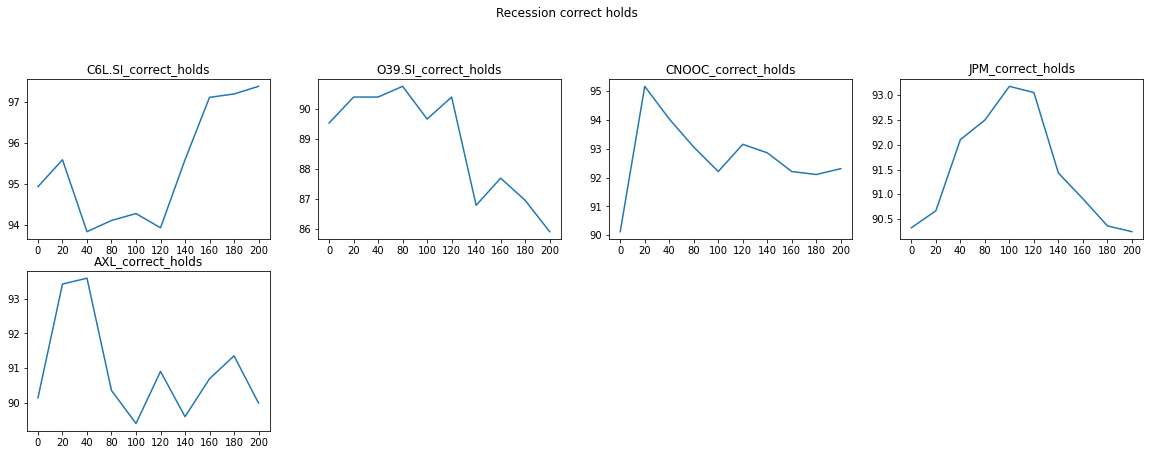

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_holds")

Text(0.5, 1.0, 'AXL_correct_low_buys')

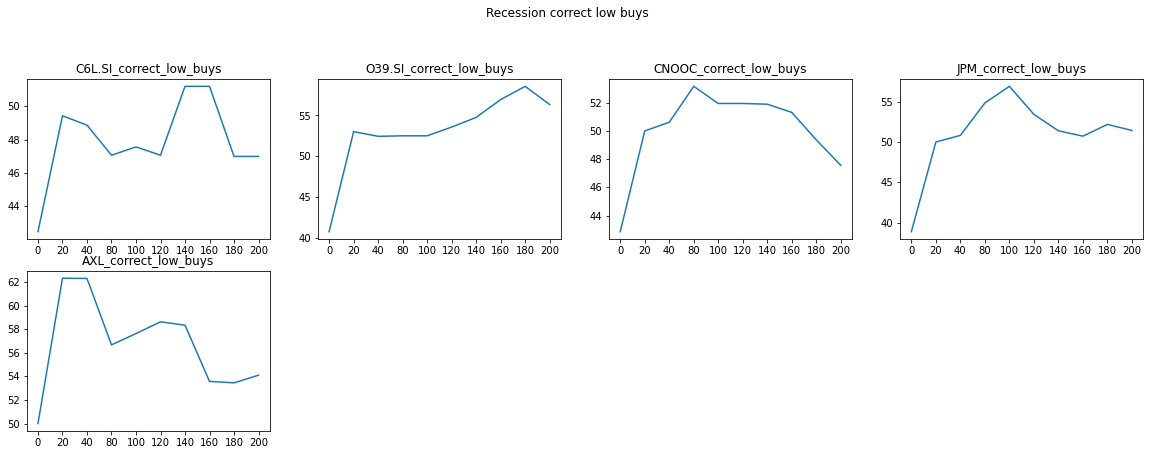

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_low_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_low_buys")

Text(0.5, 1.0, 'AXL_correct_high_sells')

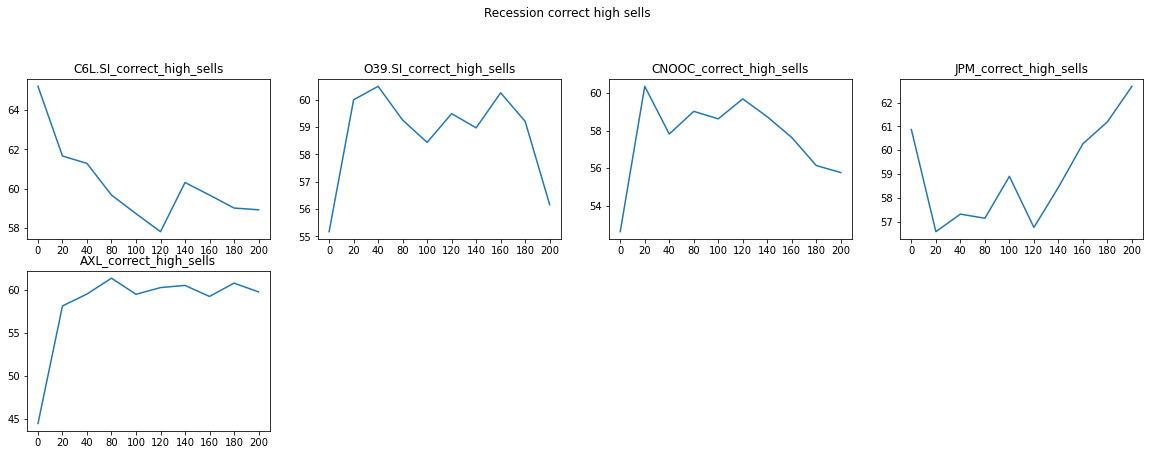

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_high_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_high_sells")

Text(0.5, 1.0, 'AXL_correct_mid_holds')

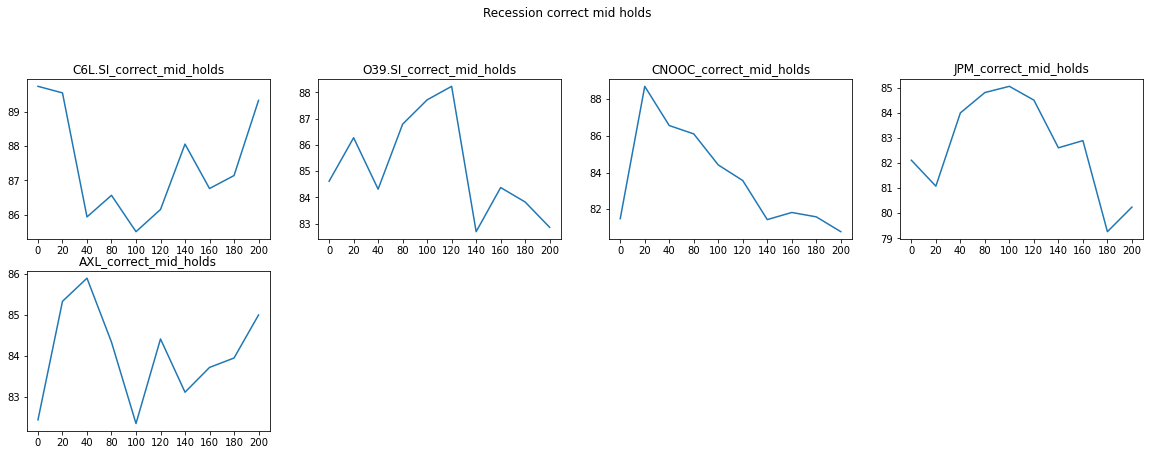

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_mid_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_mid_holds")

Text(0.5, 1.0, 'AXL_profit')

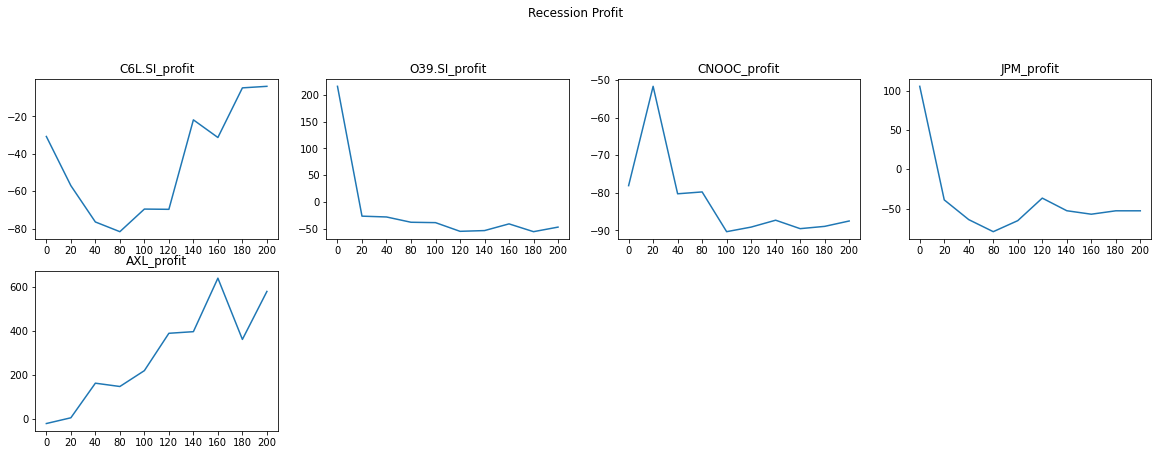

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_profit")

plt.subplot(3, 4, 2)
plt.plot(O39SI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_profit")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_profit")

plt.subplot(3, 4, 4)
plt.plot(JPM_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_profit")

plt.subplot(3, 4, 5)
plt.plot(AXL_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_profit")